In [12]:
import torch
from torch import nn, Tensor
import numpy as np
import random
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2 as transforms_v2
from torchvision.transforms import ToTensor
from torchvision.io import decode_image
import torch.optim.lr_scheduler as lr_scheduler
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import time
from PIL import Image
from datetime import datetime

In [ ]:

# Define the model and local path for saving weights
model = models.resnet18()
weights_path = "./output/resnet18_weights.pth"

# Check if the file exists locally
if os.path.exists(weights_path):
    print("✅ Loading existing ResNet-18 weights...")
    state_dict = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state_dict)
else:
    print("⬇️  Downloading ResNet-18 weights...")
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Downloads pretrained weights
    torch.save(model.state_dict(), weights_path)
    print("💾 Weights saved locally at:", weights_path)

In [13]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

Using mps device


In [14]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [15]:
class OxfordPetDataset(Dataset):
    def __init__(self, path, file_name, transform=None) -> None:
        super().__init__()
        self.filename = file_name
        self.root = Path(path)
        self.transform = transform
        self.names, self.labels = self._get_names_and_labels()
        tot_size_bytes = 0
        n_images = 0
        loaded_data = []
        idx = 0
        while idx < len(self.names):
            name = self.names[idx]
            img_tensor = self.get_img_from_filesystem(name)
            tot_size_bytes += img_tensor.numel() * img_tensor.element_size()
            n_images += 1
            loaded_data.append(img_tensor)
            idx += 1
        print("tot size", tot_size_bytes, "bytes, for", n_images, "images")
        self.data_tensor = torch.stack(loaded_data).to(device=device)
        self.labels = torch.Tensor(self.labels).type(torch.LongTensor).to(device=device)
        
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:

        label = self.labels[idx]
        img = self.data_tensor[idx]
        img = self.transform(img).to(device)

        return img, label
    
    def get_img_from_filesystem(self, name) -> Tensor:
        img_path = self.root / "images" / f"{name}.jpg"
        img = Image.open(img_path).convert("RGB")
        img = transforms_v2.Resize((256,256))(img)
        img = transforms_v2.ToTensor()(img)
        return img


    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / self.filename) as f:
            for line in f:
                if(line[0] == "#"):
                    continue
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [16]:

dataset_paths = ["/Users/leonardomassaro/Desktop/DatasetOxford_prof/", "/scratch.hpc/leomass/ipcv-assignment-2/dataset/", "/scratch.hpc/leonardo.massaro2/ipcv-assignment-2/dataset/"]
correct_path = None

for path in dataset_paths:
    if os.path.exists(path) and os.path.isdir(path):
        print("Detected dataset on ", path)
        correct_path = path
if not correct_path:
    raise Exception("No dataset found")

Detected dataset on  /Users/leonardomassaro/Desktop/DatasetOxford_prof/


In [17]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

training_transform_stack = transforms_v2.Compose([
    transforms_v2.RandomResizedCrop(size=(224, 224)),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.ColorJitter(                               
        brightness=0.5, 
        contrast=0.5, 
        saturation=0.5, 
        hue=0.1
    ),
    transforms_v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)), 
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(mean=MEAN,
                std=STD),
])

validation_transform_stack = transforms_v2.Compose([
    transforms_v2.Resize(256),
    transforms_v2.CenterCrop(224),
    transforms_v2.Normalize(MEAN, STD)
])

In [18]:
same_param_as_densenet = {
    "experiment_name": "same_param_as_densenet",
    "batch_size" : 64,
    "dropout": 0.2,
    "base_learning_rate": 0.001,
    "n_epochs": 100
}

In [19]:
train_dataset = OxfordPetDataset(correct_path, file_name="train.txt" , transform=training_transform_stack)
validation_dataset = OxfordPetDataset(correct_path, file_name="val.txt" , transform=validation_transform_stack)
test_dataset = OxfordPetDataset(correct_path, file_name="test.txt" , transform=validation_transform_stack)

train_dataloader = DataLoader(train_dataset, batch_size=same_param_as_densenet["batch_size"], shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=same_param_as_densenet["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=same_param_as_densenet["batch_size"], shuffle=True)

tot size 90439680 bytes, for 115 images


KeyboardInterrupt: 

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=same_param_as_densenet["base_learning_rate"])

main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15)


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

In [ ]:

N_CLASSES = 37   

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace the fully connected head
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.ReLU(),
    nn.Linear(in_features, N_CLASSES)
).to(device)

results = {
    "train_loss": [],
    "val_accuracy": [],
    "val_loss": []
}

# --- TRAINING LOOP ---
for epoch in range(same_param_as_densenet["n_epochs"]):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss/len(train_dataloader)
    val_accuracy, val_loss = test(validation_dataloader, model, loss_fn)
    main_scheduler.step(val_accuracy)
    results["train_loss"].append(train_loss)
    results["val_accuracy"].append(val_accuracy)
    results["val_loss"].append(val_loss)

    print(f"Epoch [{epoch+1}/{same_param_as_densenet["n_epochs"]}] Loss: {train_loss:.4f}")

print("Training complete")

<Axes: >

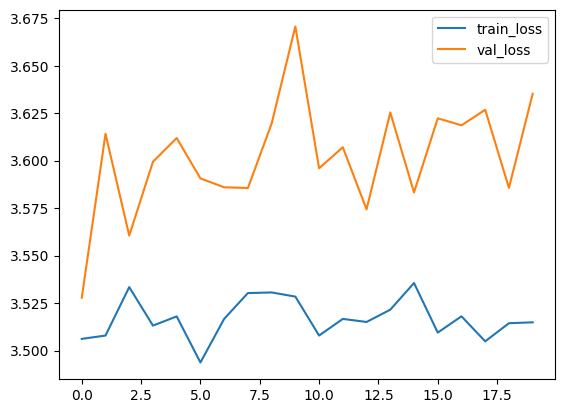

In [ ]:
res_df = pd.DataFrame(results)
res_df[["train_loss", "val_loss"]].plot()

<Axes: >

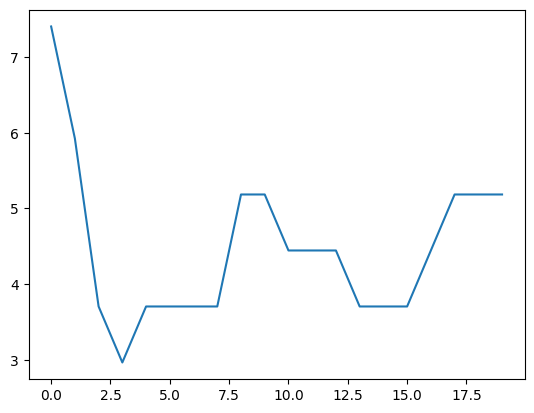

In [ ]:
res_df["val_accuracy"].plot()